In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchok.data.transforms import (
    Compose,
    PadIfNeeded,
    Crop,
    Normalize,
    ToTensorV2,
)

from russian_htr import HandwrittenDataset, GroupSampler
from russian_htr import StringEncoder, Generator, count_parameters

In [3]:
BATCH_SIZE = 2

# datasets params
DS = "IAM"  # "IAM" or "CVL"
HEIGHT = 32
WIDTH = 192
DS_PATH = f"/home/d.nesterov/russian-htr/data/{DS}-32.pickle"

In [4]:
# Handwritten Dataset creation example

transform = Compose([
	PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, border_mode=0, value=0),
	Crop(y_max=HEIGHT, x_max=WIDTH),
	Normalize(),
	ToTensorV2()
])

ds_train = HandwrittenDataset(DS_PATH, mode='train', transform=transform)

In [5]:
# GroupSampler usage example

sampler = GroupSampler(ds_train, BATCH_SIZE, drop_last=True)
dl = DataLoader(ds_train, batch_sampler=sampler)

# total = 0
# for i, batch in enumerate(dl):
# 	total += len(batch['image'])
# print(f"Total images: {total}, ds len: {len(ds_train)}, n_batches: {i}")

In [6]:
batch = next(iter(dl))

In [7]:
vocab = ' !#%()*+,-./":;?\'&abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

In [24]:
sample_text = 'ahahhha hello lets goooo booooy world!'
converter = StringEncoder(vocab)

In [25]:
text = [word.encode() for word in sample_text.split()]
encoded_text, eval_len_text = converter.encode(text)
# encoded_text = encoded_text.repeat(BATCH_SIZE, 1, 1)
print(encoded_text.shape, eval_len_text)

torch.Size([6, 7]) tensor([7, 5, 4, 5, 6, 6], dtype=torch.int32)


In [20]:
gen = Generator(vocab_size=len(vocab), hidden_dim=128, dim_feedforward=512, num_encoder_layers=1, num_decoder_layers=1)
print(f"Number of parameters: {count_parameters(gen)}")

Number of parameters: 20772289


In [11]:
batch['image'].shape

torch.Size([2, 3, 32, 192])

In [22]:
src = batch['image'].flatten(2).permute(2, 0, 1)

y_emb = gen.char_embedder(encoded_text).permute(1, 0, 2)
print(y_emb.shape)

torch.Size([7, 3, 512])


In [23]:
res = gen(batch['image'], encoded_text)

RuntimeError: shape '[72, 24, 64]' is invalid for input of size 73728

In [55]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def imshow(img, title=None, plt_ax=plt, default=False):
    img = img.numpy().transpose((1, 2, 0))
    img = STD * img + MEAN
    img = np.clip(img, 0, 1)
    plt_ax.imshow(img)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

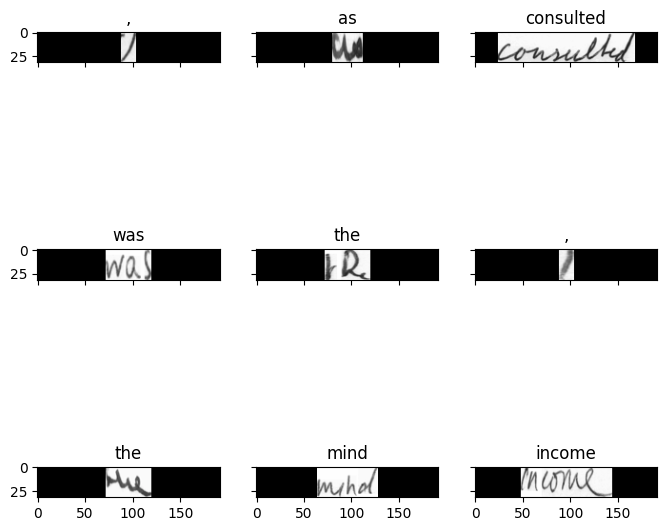

In [61]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    idx = np.random.randint(len(ds_train))
    sample = ds_train[idx]
    imshow(sample['image'], title=sample['target'], plt_ax=fig_x)
plt.show()